In [27]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (10, 5), 'font.size': 12, 'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

import numpy as np
from numba import njit
import networkx as nx
import percolate
from pprint import pprint

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, 'percolation')

import time
import os
from multiprocess import Pool
num_cpus = len(os.sched_getaffinity(0)) // 2
print("Using {} CPUs.".format(num_cpus))

Using 4 CPUs.


In [28]:
# number of runs
chain_runs = 40
# system sizes
chain_ls = [10, 100, 1000, 10000]

In [29]:
# generate the linear chain graphs with spanning cluster detection
# for all system sizes
chain_graphs = [ percolate.spanning_1d_chain(l) for l in chain_ls ]

In [30]:
# compute the microcanonical averages for all system sizes
chain_microcanonical_averages = [
    percolate.microcanonical_averages(
        graph=chain_graph, runs=chain_runs
    )
    for chain_graph in chain_graphs
]
# combine microcanonical averages into one array
chain_microcanonical_averages_arrays = [
    percolate.microcanonical_averages_arrays(avg)
    for avg in chain_microcanonical_averages
]

In [33]:
# occupation probabilities
chain_ps_arrays = [ np.linspace(1.0 - x, 0.999, num=100) for x in [0.999, 0.1, 0.01] ]

In [34]:
# compute canonical averages from microcanonical averages
# for all occupation probabilities and system sizes
chain_stats = [
    [
        percolate.canonical_averages(ps, avg_arrays)
        for avg_arrays in chain_microcanonical_averages_arrays
    ]
    for ps in chain_ps_arrays
]

FloatingPointError: underflow encountered in true_divide

NameError: name 'chain_stats' is not defined

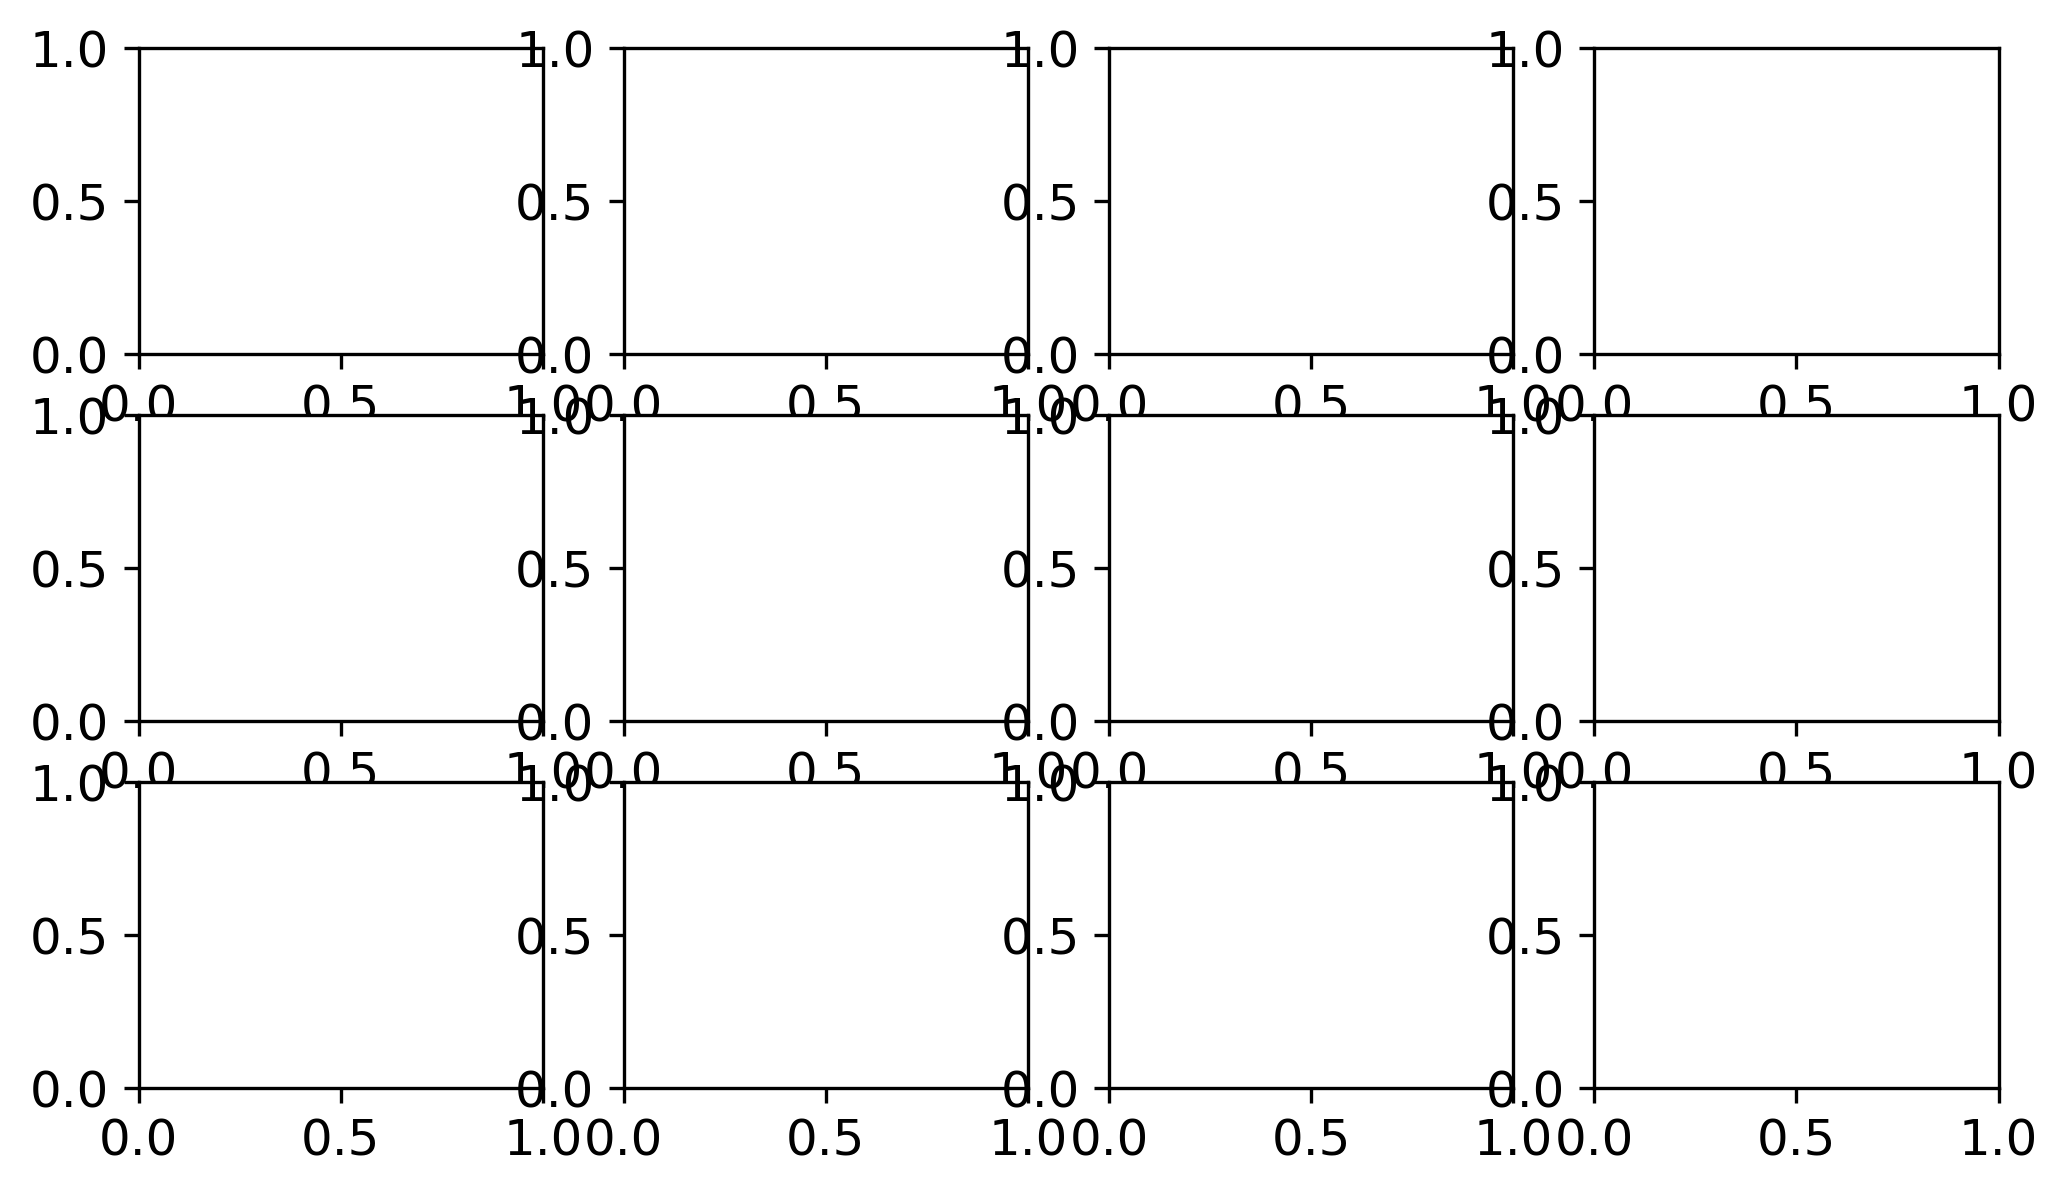

In [ ]:
# plot
fig, axes = plt.subplots(
    nrows=len(chain_ps_arrays), ncols=4, squeeze=True, figsize=(8.0, 4.5)
)
for ps_index, ps in enumerate(chain_ps_arrays):
    for l_index, l in enumerate(chain_ls):
        my_stats = chain_stats[ps_index][l_index]

        line, = axes[ps_index, 0].plot(
            ps,
            my_stats['spanning_cluster'],
            rasterized=True,
            label=r'{}'.format(l),
        )
        axes[ps_index, 0].fill_between(
            ps,
            my_stats['spanning_cluster_ci'].T[1],
            my_stats['spanning_cluster_ci'].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        line, = axes[ps_index, 1].plot(
            ps,
            my_stats['max_cluster_size'],
            rasterized=True,
            label=r'L={}'.format(l),
        )
        axes[ps_index, 1].fill_between(
            ps,
            my_stats['max_cluster_size_ci'].T[1],
            my_stats['max_cluster_size_ci'].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        axes[ps_index, 2].plot(
            ps,
            my_stats['moments'][2],
            rasterized=True,
            label=r'L={}'.format(l),
        )
        axes[ps_index, 2].fill_between(
            ps,
            my_stats['moments_ci'][2].T[1],
            my_stats['moments_ci'][2].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        axes[ps_index, 3].semilogy(
            ps,
            my_stats['moments'][2],
            rasterized=True,
        )
        axes[ps_index, 3].fill_between(
            ps,
            np.where(
                my_stats['moments_ci'][2].T[1] > 0.0,
                my_stats['moments_ci'][2].T[1],
                0.01
            ),
            np.where(
                my_stats['moments_ci'][2].T[0] > 0.0,
                my_stats['moments_ci'][2].T[0],
                0.01
            ),
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )


    axes[ps_index, 0].set_ylim(ymax=1.0)
    axes[ps_index, 1].set_ylim(ymax=1.0)
    axes[ps_index, 2].set_ylim(ymin=0.0)
    axes[ps_index, 3].set_ylim(ymin=0.5)

    for ax in axes[ps_index, :]:
        ax.set_xlim(xmin=ps.min(), xmax=ps.max() + (ps.max() - ps.min()) * 0.05)
        ax.set_xticks(np.linspace(ps.min(), ps.max(), num=3))

    for ax in axes[ps_index, :-1]:
        ax.set_yticks(np.linspace(0, ax.get_ylim()[1], num=3))

axes[0, 0].set_title(r'perc. probability')
axes[0, 1].set_title(r'perc. strength')
axes[0, 2].set_title(r'$\langle M_2 \rangle$')
axes[0, 3].set_title(r'$\langle M_2 \rangle$')

for ax in axes[-1, :]:
    ax.set_xlabel(r'$p$')

axes[0, 2].legend(frameon=False, loc='center left')

plt.tight_layout(0)
plt.show()